In [5]:
# ! pip install optuna

In [6]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
path_train = "./data/project_train.csv"
df = pd.read_csv(path_train, index_col=0)

# Set preprocessing threshold
preprocessing_threshold = 0.0

# Separate features and target
X = df.drop("TARGET", axis=1)
y_raw = df["TARGET"]
y = (df["TARGET"] > preprocessing_threshold).astype(int)

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
train_valid_splits = list(tscv.split(X))


def threshold_sum(y_true, y_pred_proba, threshold):
    """
    Calculate the sum of original targets for which the model predictions are above the threshold.
    """
    adjusted_target = np.where(y_pred_proba > threshold, df["TARGET"].iloc[y_true.index], 0)
    return np.sum(adjusted_target)


def objective(trial):
    C = trial.suggest_float("C", 1e-5, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1)

    # Create pipeline with StandardScaler and LogisticRegression
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C, penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, random_state=42, max_iter=200),
    )

    log_loss_scores = []
    auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    custom_metric_values = []

    for train_index, valid_index in train_valid_splits:
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict(X_valid)

        log_loss_scores.append(log_loss(y_valid, y_pred_proba))
        auc_scores.append(roc_auc_score(y_valid, y_pred_proba))
        accuracy_scores.append(accuracy_score(y_valid, y_pred))
        precision_scores.append(precision_score(y_valid, y_pred))
        recall_scores.append(recall_score(y_valid, y_pred))
        f1_scores.append(f1_score(y_valid, y_pred))

        custom_metric_value = threshold_sum(y_valid, y_pred_proba, 0.5)
        custom_metric_values.append(custom_metric_value)

    mean_log_loss = np.mean(log_loss_scores)
    mean_auc = np.mean(auc_scores)
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    total_custom_metric_value = sum(custom_metric_values)

    trial.set_user_attr("mean_auc", mean_auc)
    trial.set_user_attr("mean_accuracy", mean_accuracy)
    trial.set_user_attr("mean_precision", mean_precision)
    trial.set_user_attr("mean_recall", mean_recall)
    trial.set_user_attr("mean_f1", mean_f1)
    trial.set_user_attr("sum_custom_metric", total_custom_metric_value)

    return mean_log_loss


# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best trial:")
trial = study.best_trial
print("  Log Loss: ", trial.value)
print("  AUC: ", trial.user_attrs["mean_auc"])
print("  Accuracy: ", trial.user_attrs["mean_accuracy"])
print("  Precision: ", trial.user_attrs["mean_precision"])
print("  Recall: ", trial.user_attrs["mean_recall"])
print("  F1 Score: ", trial.user_attrs["mean_f1"])
print("  Custom Metric: ", trial.user_attrs["sum_custom_metric"])
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Save the study
joblib.dump(study, "./studies/logistic_regression_optuna_study.pkl")

# Train final model with best parameters using pipeline
best_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=trial.params["C"],
        penalty="elasticnet",
        solver="saga",
        l1_ratio=trial.params["l1_ratio"],
        random_state=42,
        max_iter=200,
    ),
)

best_model.fit(X, y)

# Save the final model (no need to save scaler separately)
joblib.dump(best_model, "./models/best_logistic_regression_pipeline.pkl")

print("\nOptimization complete. Study and best model saved.")

[I 2024-10-20 18:08:53,256] A new study created in memory with name: no-name-78fea41b-55ce-4e1a-b6b2-507cda551f99
[I 2024-10-20 18:09:02,645] Trial 1 finished with value: 0.6931925912969464 and parameters: {'C': 6.894000638081374e-05, 'l1_ratio': 0.9794715164126868}. Best is trial 1 with value: 0.6931925912969464.
[I 2024-10-20 18:09:03,000] Trial 0 finished with value: 0.6931919913729465 and parameters: {'C': 3.06484525122741e-05, 'l1_ratio': 0.24240490304395723}. Best is trial 0 with value: 0.6931919913729465.
[I 2024-10-20 18:09:23,440] Trial 3 finished with value: 0.6920690992198646 and parameters: {'C': 0.0014370612693651937, 'l1_ratio': 0.7728869790190082}. Best is trial 3 with value: 0.6920690992198646.
[I 2024-10-20 18:09:30,749] Trial 4 finished with value: 0.6931929607120516 and parameters: {'C': 3.0119977285700066e-05, 'l1_ratio': 0.7632791335010689}. Best is trial 3 with value: 0.6920690992198646.
[I 2024-10-20 18:09:59,202] Trial 5 finished with value: 0.691543536776835 an

Best trial:
  Log Loss:  0.6914582887762662
  AUC:  0.5354094657591422
  Accuracy:  0.5282666666666668
  Precision:  0.5265407366628387
  Recall:  0.5559433812745631
  F1 Score:  0.5403545934744146
  Custom Metric:  -15.069265236999984
  Params: 
    C: 0.003941236204957917
    l1_ratio: 0.4010657419942142

Optimization complete. Study and best model saved.


<ipython-input-7-19f02c9358f3>:26: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


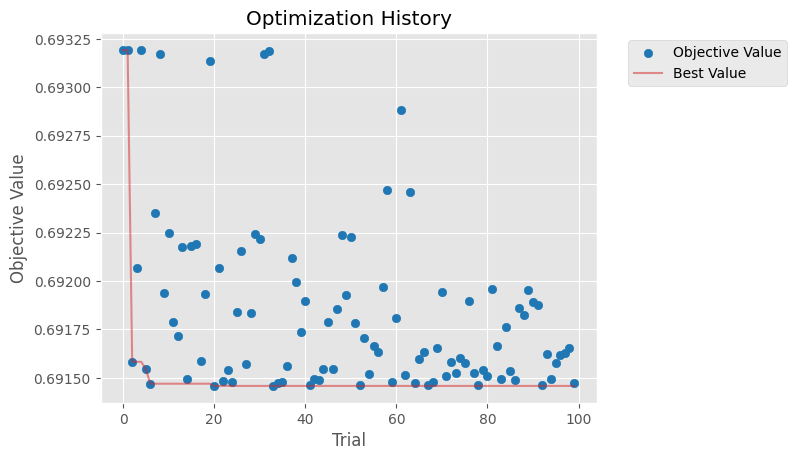

<ipython-input-7-19f02c9358f3>:32: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


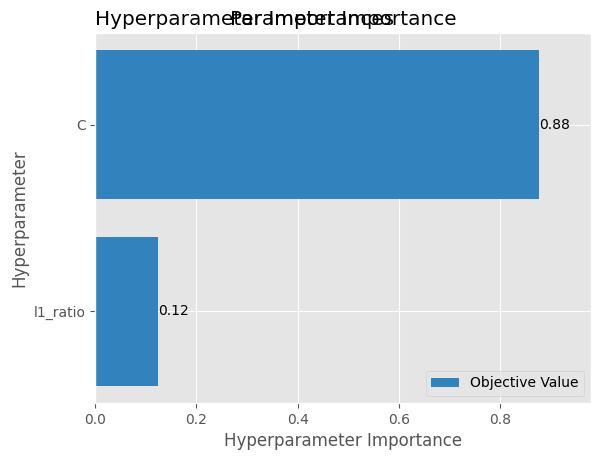

<ipython-input-7-19f02c9358f3>:38: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


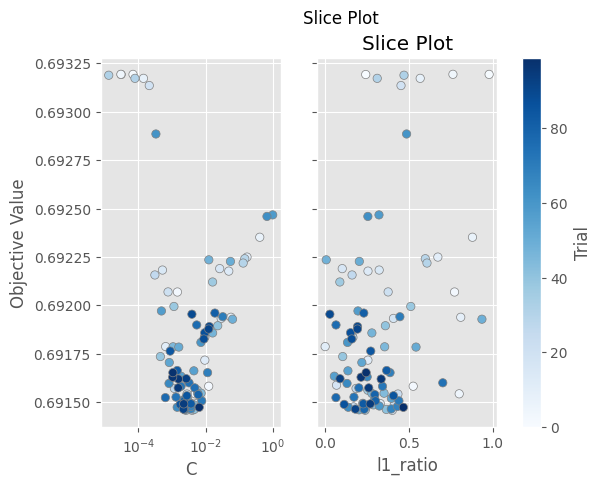

<ipython-input-7-19f02c9358f3>:44: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2024-10-20 18:47:33,305] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


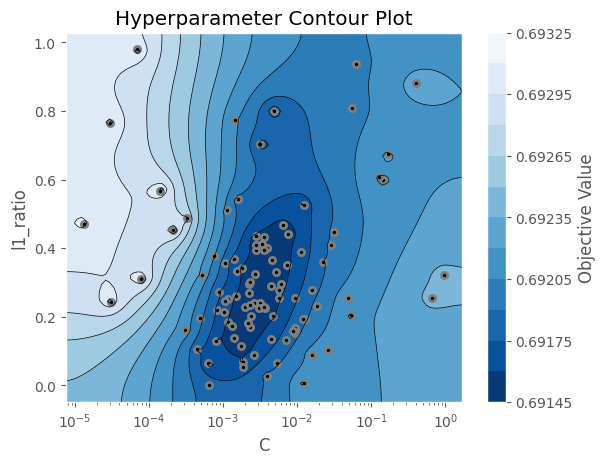

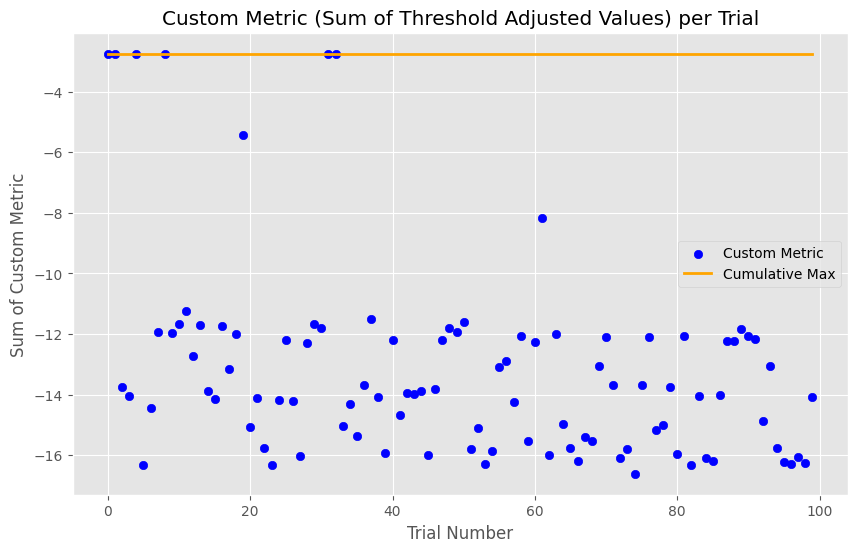

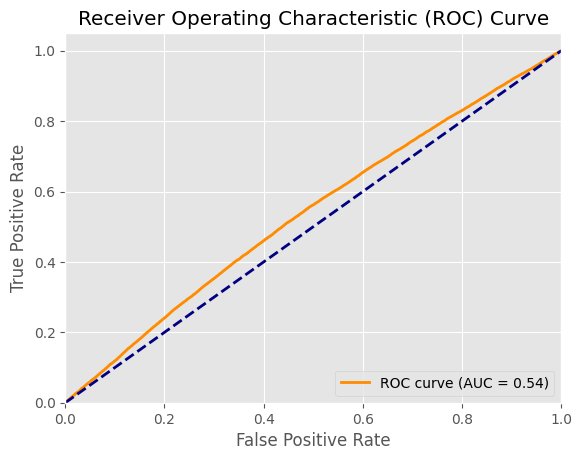

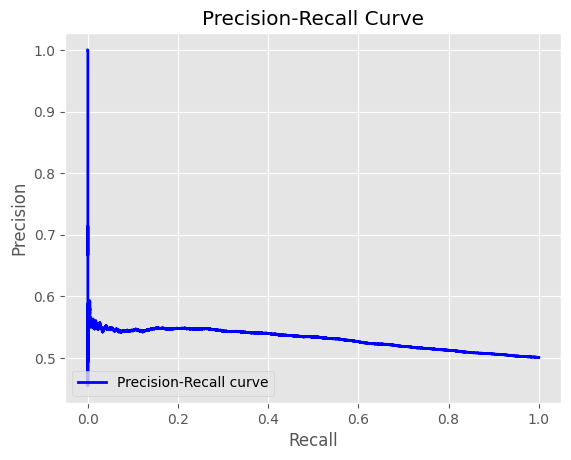

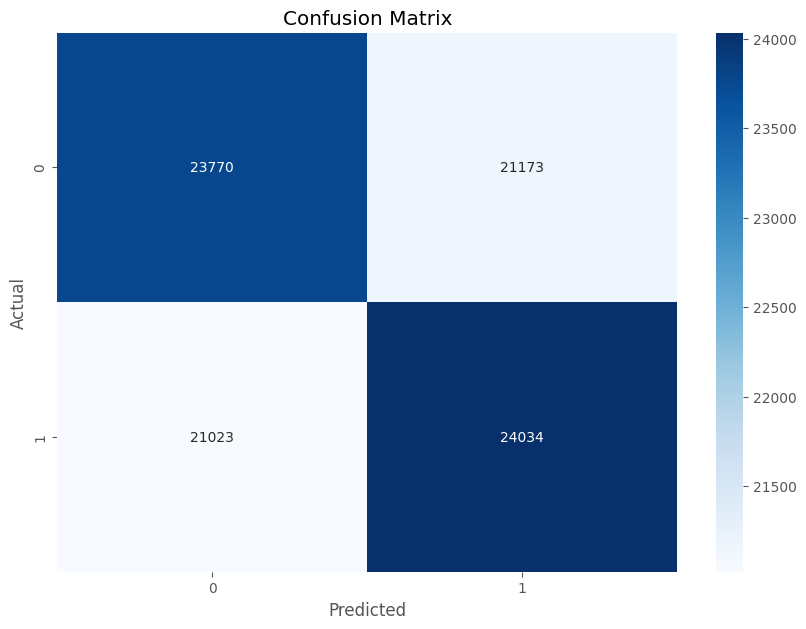

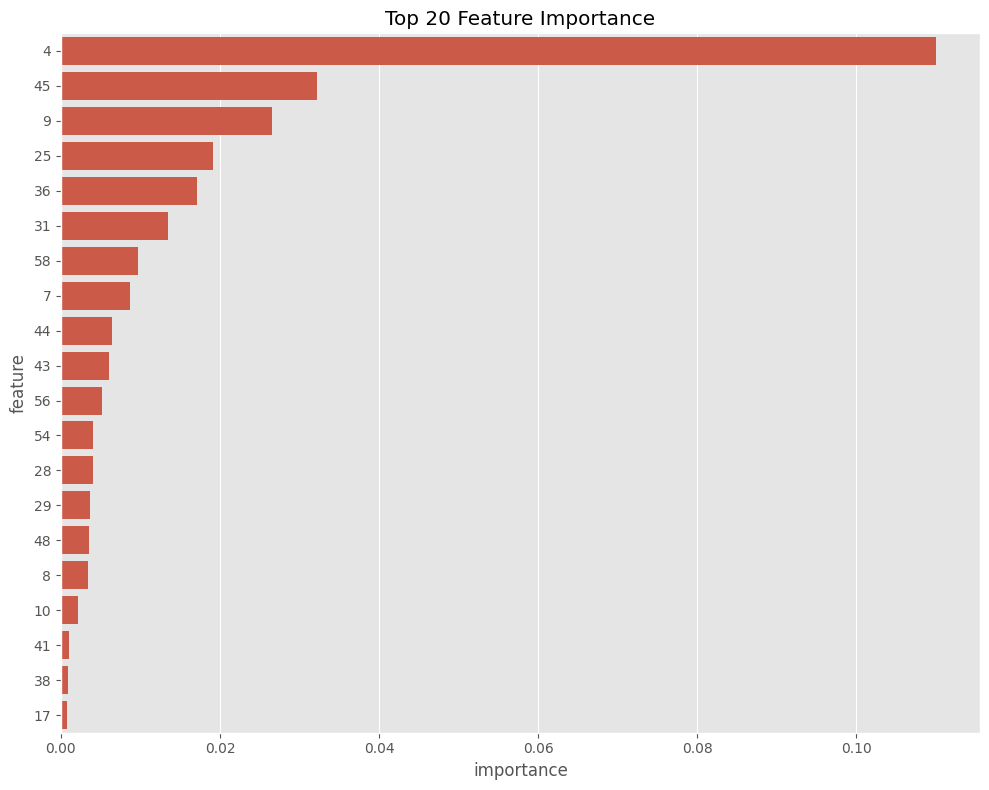

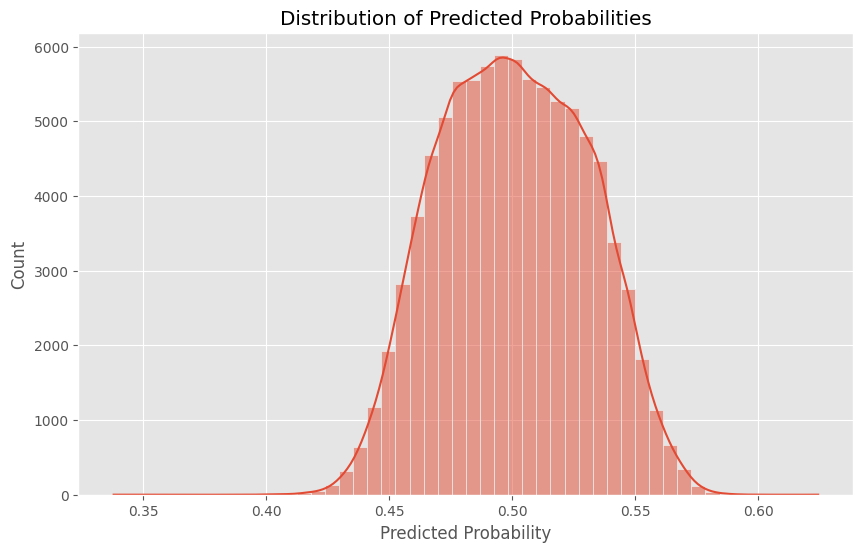


Model Performance Metrics:
Accuracy: 0.5312
Precision: 0.5316
Recall: 0.5334
F1 Score: 0.5325
Log Loss: 0.6910
AUC: 0.5385

Metrics have been saved to 'logistic_regression_metrics.txt' in the 'studies' directory.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
import optuna.visualization as vis

# Load the best model and the study
best_model = joblib.load("./models/best_logistic_regression_pipeline.pkl")
study = joblib.load("./studies/logistic_regression_optuna_study.pkl")

# Load the data
path_train = "./data/project_train.csv"
df = pd.read_csv(path_train, index_col=0)

# Separate features and target
X = df.drop("TARGET", axis=1)
y = (df["TARGET"] > 0.0).astype(int)

# Predict probabilities and classes
y_pred_proba = best_model.predict_proba(X)[:, 1]
y_pred = best_model.predict(X)

# Plot the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.savefig("./plots/optimization_history.png")
plt.show()

# Plot parameter importance
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importance")
plt.savefig("./plots/param_importance.png")
plt.show()

# Plot slice plot for detailed analysis
optuna.visualization.matplotlib.plot_slice(study)
plt.title("Slice Plot")
plt.savefig("./plots/slice_plot.png")
plt.show()

# Plot contour plot for interactions between parameters
optuna.visualization.matplotlib.plot_contour(study)
plt.title("Hyperparameter Contour Plot")
plt.savefig("./plots/contour_plot.png")
plt.show()

# Extract custom metric values from the study
custom_metric_values = [trial.user_attrs["sum_custom_metric"] for trial in study.trials]
cumulative_max = np.maximum.accumulate(custom_metric_values)

# Create the scatter plot and the line for the cumulative max
plt.figure(figsize=(10, 6))
plt.scatter(range(len(custom_metric_values)), custom_metric_values, label="Custom Metric", color="blue")
plt.plot(cumulative_max, label="Cumulative Max", color="orange", linewidth=2)
plt.title("Custom Metric (Sum of Threshold Adjusted Values) per Trial")
plt.xlabel("Trial Number")
plt.ylabel("Sum of Custom Metric")
plt.grid(True)
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.savefig("./plots/roc_curve.png")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color="blue", lw=2, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.savefig("./plots/precision_recall_curve.png")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("./plots/confusion_matrix.png")
plt.show()

# Feature Importance
importance = np.abs(best_model.named_steps["logisticregression"].coef_[0])
feature_importance = pd.DataFrame({"feature": X.columns, "importance": importance})
feature_importance = feature_importance.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=feature_importance.head(20))
plt.title("Top 20 Feature Importance")
plt.tight_layout()
plt.savefig("./plots/feature_importance.png")
plt.show()

# Distribution of Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.savefig("./plots/probability_distribution.png")
plt.show()

# Calculate and print various metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
logloss = log_loss(y, y_pred_proba)

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Save metrics to a file
with open("./studies/logistic_regression_metrics.txt", "w") as f:
    f.write(f"Model Performance Metrics:\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"Log Loss: {logloss:.4f}\n")
    f.write(f"AUC: {roc_auc:.4f}\n")

print("\nMetrics have been saved to 'logistic_regression_metrics.txt' in the 'studies' directory.")

Custom Threshold Sum (Threshold = 0.5): -14.126378817899985


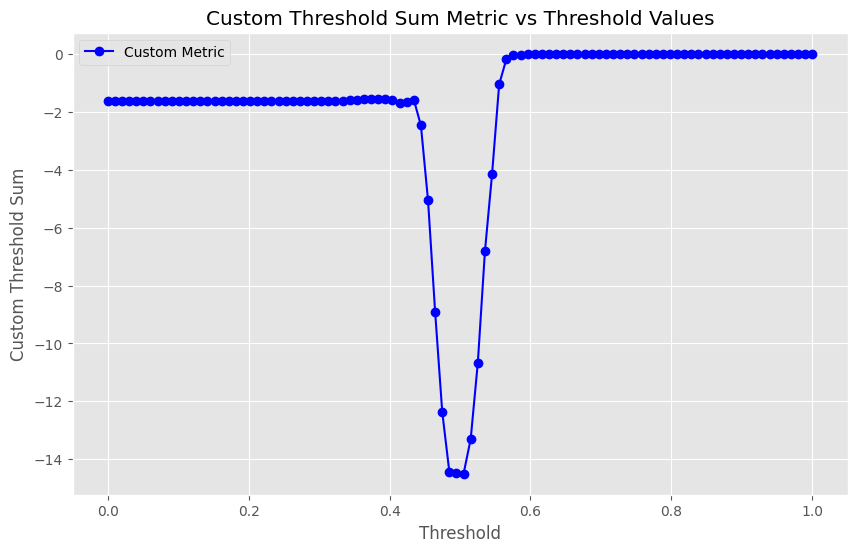

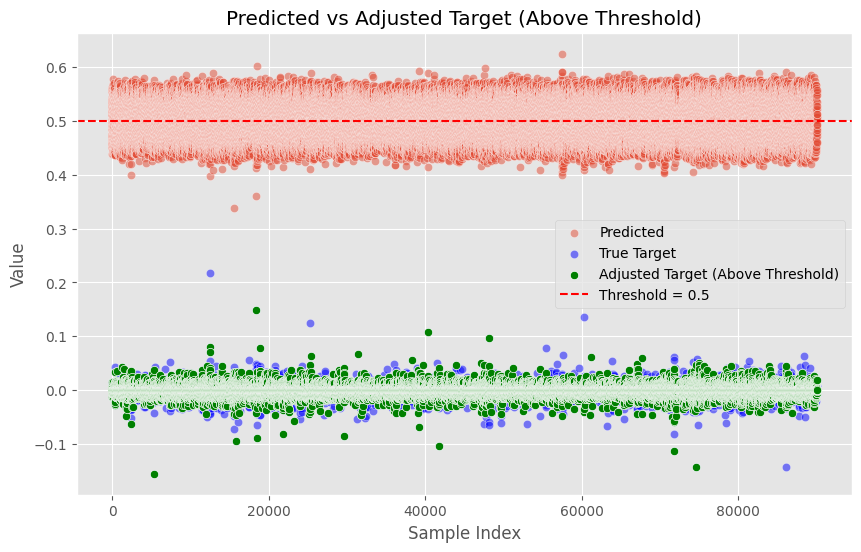

In [13]:
y_pred_proba = best_model.predict_proba(X)[:, 1]
threshold = 0.5

custom_metric_value = threshold_sum(y, y_pred, threshold)
print(f"Custom Threshold Sum (Threshold = {threshold}): {custom_metric_value}")

threshold_values = np.linspace(0, 1, 100)
custom_metric_values = []

for threshold in threshold_values:
    custom_metric_value = threshold_sum(y, y_pred_proba, threshold)
    custom_metric_values.append(custom_metric_value)

# Plot the custom metric vs threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, custom_metric_values, marker="o", color="b", label="Custom Metric")
plt.title("Custom Threshold Sum Metric vs Threshold Values")
plt.xlabel("Threshold")
plt.ylabel("Custom Threshold Sum")
plt.grid(True)
plt.legend()
plt.savefig("./plots/custom_metric_vs_threshold.png")
plt.show()


# Plot for a selected threshold
threshold = 0.5
adjusted_y = np.where(y_pred > threshold, y_raw, 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(y)), y=y_pred_proba, label="Predicted", alpha=0.5)
sns.scatterplot(x=range(len(y)), y=y_raw, label="True Target", color="blue", alpha=0.5)
sns.scatterplot(x=range(len(y)), y=adjusted_y, label="Adjusted Target (Above Threshold)", color="green")
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
plt.title("Predicted vs Adjusted Target (Above Threshold)")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.savefig("./plots/predicted_vs_adjusted_threshold.png")
plt.show()